In [1]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

2025-04-21 12:43:43.942415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745239424.145441      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745239424.206765      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **ĐỌC DỮ LIỆU 8 NHÃN**

📌 Nhãn Mirai: Thêm 13,351 dòng, tổng cộng 13,351 dòng
📌 Nhãn DDoS: Thêm 174,841 dòng, tổng cộng 174,841 dòng
📌 Nhãn Spoofing: Thêm 2,572 dòng, tổng cộng 2,572 dòng
📌 Nhãn BENIGN: Thêm 5,645 dòng, tổng cộng 5,645 dòng
📌 Nhãn DoS: Thêm 41,221 dòng, tổng cộng 41,221 dòng
📌 Nhãn Recon: Thêm 1,876 dòng, tổng cộng 1,876 dòng
📌 Nhãn BruteForce: Thêm 55 dòng, tổng cộng 55 dòng
📌 Nhãn Web-based: Thêm 105 dòng, tổng cộng 105 dòng
📌 File 0: Giữ 239,666 dòng sau khi lọc giới hạn
📌 Nhãn Recon: Thêm 1,888 dòng, tổng cộng 3,764 dòng
📌 Nhãn DoS: Thêm 41,933 dòng, tổng cộng 83,154 dòng
📌 Nhãn DDoS: Thêm 176,390 dòng, tổng cộng 351,231 dòng
📌 Nhãn Mirai: Thêm 13,615 dòng, tổng cộng 26,966 dòng
📌 Nhãn Spoofing: Thêm 2,544 dòng, tổng cộng 5,116 dòng
📌 Nhãn BENIGN: Thêm 5,778 dòng, tổng cộng 11,423 dòng
📌 Nhãn Web-based: Thêm 147 dòng, tổng cộng 252 dòng
📌 Nhãn BruteForce: Thêm 70 dòng, tổng cộng 125 dòng
📌 File 1: Giữ 242,365 dòng sau khi lọc giới hạn
📌 Nhãn DoS: Thêm 40,184 dòng, tổng cộng 123,338 dòng
📌

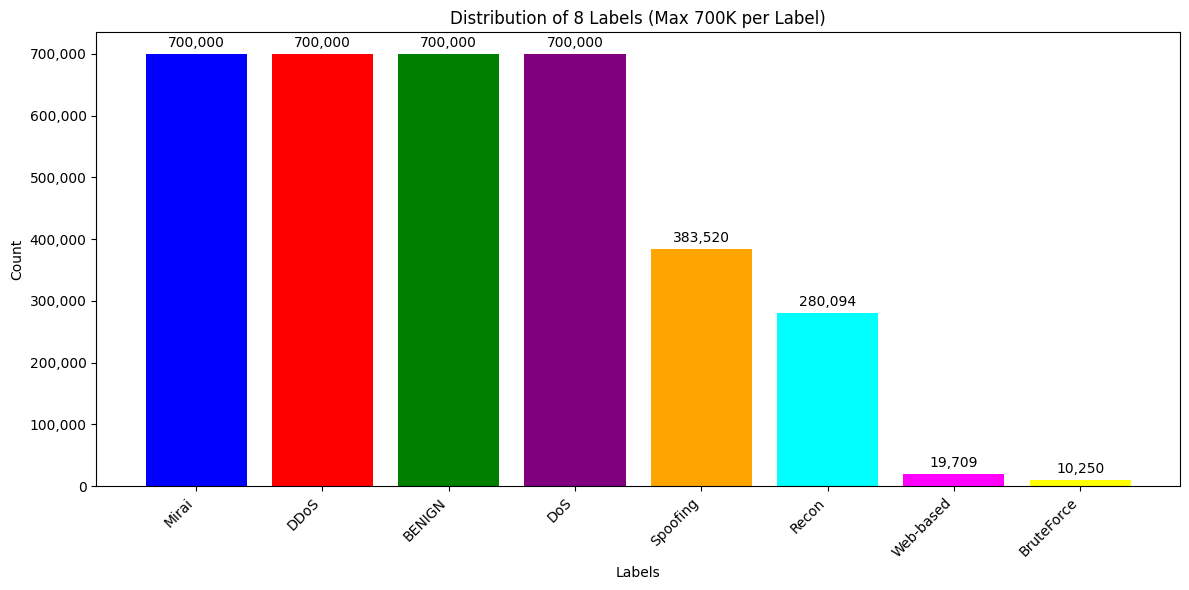

In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Hàm ánh xạ nhãn thành 8 nhóm
def change_label(df):
    mapping = {
        'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS',
        'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS',
        'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
        'DDoS-HTTP_Flood': 'DDoS', 'DDoS-SlowLoris': 'DDoS',
        'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
        'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
        'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
        'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
        'DictionaryBruteForce': 'BruteForce',
        'BrowserHijacking': 'Web-based', 'XSS': 'Web-based', 'Uploading_Attack': 'Web-based',
        'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based',
        'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai',
        'BenignTraffic': 'BENIGN'
    }
    df["label"] = df["label"].map(mapping).fillna(df["label"])
    return df

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:134]  # Lấy tối đa 134 file

# Giới hạn tối đa 700,000 dòng cho mỗi nhãn
MAX_ROWS_PER_LABEL = 700_000
label_counts = {
    "DDoS": 0, "DoS": 0, "Recon": 0, "Spoofing": 0,
    "BruteForce": 0, "Web-based": 0, "Mirai": 0, "BENIGN": 0
}  # Theo dõi số dòng của từng nhãn

def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Ánh xạ nhãn thành 8 nhóm
        df = change_label(df)
        
        # Lọc dữ liệu dựa trên giới hạn 700K cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và vẽ biểu đồ
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để vẽ biểu đồ
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn
    print("\n📋 Phân bố nhãn sau khi gộp:")
    print(df_pandas["label"].value_counts())
    
    # Vẽ biểu đồ phân bố nhãn
    fig, ax = plt.subplots(figsize=(12, 6))
    label_counts = df_pandas["label"].value_counts()

    bars = ax.bar(label_counts.index, label_counts.values, color=['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of 8 Labels (Max 700K per Label)')

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_8labels_700K.png')  # Lưu biểu đồ
    plt.show()
    
   
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

# **ÁNH XẠ NHÃN**

📋 Nhãn duy nhất trong dữ liệu: ['Mirai', 'DDoS', 'Spoofing', 'BENIGN', 'DoS', 'Recon', 'BruteForce', 'Web-based']
📊 Ánh xạ nhãn (8 nhãn): {'BENIGN': 0, 'BruteForce': 1, 'DDoS': 2, 'DoS': 3, 'Mirai': 4, 'Recon': 5, 'Spoofing': 6, 'Web-based': 7}

📊 Phân bố nhãn trong tập huấn luyện:
4    455000
3    455000
0    455000
2    455000
6    249288
5    182061
7     12811
1      6662
Name: count, dtype: int64

📊 Phân bố nhãn trong tập validation:
4    105000
2    105000
3    105000
0    105000
6     57528
5     42014
7      2956
1      1538
Name: count, dtype: int64

📊 Phân bố nhãn trong tập kiểm tra:
2    140000
4    140000
3    140000
0    140000
6     76704
5     56019
7      3942
1      2050
Name: count, dtype: int64
🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:
            IAT   Tot size        Max    Tot sum  Magnitue        AVG  \
min -102.948895  -0.121421  -0.331599  -0.201901 -0.236738  -0.131373   
max  104.652005  26.143223  90.694424  23.547410  6.457749  26.132148   

     

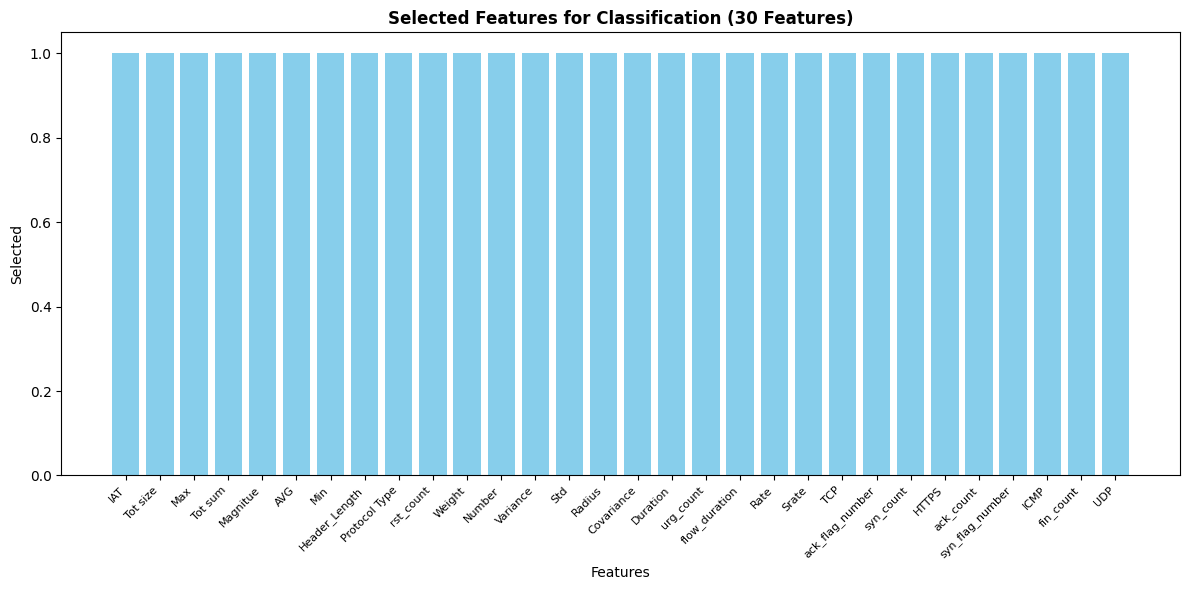

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())

# Danh sách 30 đặc trưng đã chọn
selected_features = [
    'IAT', 'Tot size', 'Max', 'Tot sum', 'Magnitue', 'AVG', 'Min', 'Header_Length', 
    'Protocol Type', 'rst_count', 'Weight', 'Number', 'Variance', 'Std', 'Radius', 
    'Covariance', 'Duration', 'urg_count', 'flow_duration', 'Rate', 'Srate', 'TCP', 
    'ack_flag_number', 'syn_count', 'HTTPS', 'ack_count', 'syn_flag_number', 'ICMP', 
    'fin_count', 'UDP'
]

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in selected_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng đã chọn
feature_indices = [list(X.columns).index(f) for f in selected_features]

# Áp dụng các đặc trưng đã chọn trước khi chia dữ liệu
X = X[selected_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (8 nhãn: DDoS, DoS, Recon, Spoofing, BruteForce, Web-based, Mirai, BENIGN)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("📊 Ánh xạ nhãn (8 nhãn):", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename(label_mapping))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename(label_mapping))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=selected_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=selected_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_8labels.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_8labels.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_8labels.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_8labels.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_8labels.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_8labels.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_8labels.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_8labels.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_8labels.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_8labels.pkl", 'wb') as f:
    pickle.dump(selected_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(selected_features)}")
print(f"📋 Các đặc trưng được chọn: {selected_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(12, 6))
plt.bar(selected_features, [1] * len(selected_features), color='skyblue')
plt.title('Selected Features for Classification (30 Features)', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_8labels.png")
plt.show()

# **LẤY CÁC SOFT LABLE**

In [5]:
import numpy as np
import xgboost as xgb
import joblib
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu đã xử lý (8 nhãn, 30 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels.npy")

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_scaled: {X_train_scaled.shape}")
print(f"📏 Kích thước X_val_scaled: {X_val_scaled.shape}")
print(f"📏 Kích thước X_test_scaled: {X_test_scaled.shape}")
print(f"📋 Nhãn duy nhất trong Y_train_encoded: {np.unique(Y_train_encoded)}")

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
joblib.dump(scaler, f"{results_dir}/xgboost_scaler_8labels.pkl")
tqdm.write(f"📦 Lưu StandardScaler tại {results_dir}/xgboost_scaler_8labels.pkl")

# Thiết lập tham số XGBoost cho phân loại đa lớp
xgb_params = {
    'objective': 'multi:softprob',  # Phân loại đa lớp, trả về xác suất
    'num_class': 8,  # Số lượng nhãn (8 nhãn)
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,  # Giảm số cây để tăng tốc độ
    'eval_metric': 'mlogloss',  # Sử dụng mlogloss cho đa lớp
    'random_state': 42
}

# Huấn luyện mô hình XGBoost
tqdm.write("🚀 Bắt đầu huấn luyện XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train_scaled, Y_train_encoded)

# Lấy soft labels (xác suất)
soft_labels_train = xgb_model.predict_proba(X_train_scaled)
soft_labels_val = xgb_model.predict_proba(X_val_scaled)
soft_labels_test = xgb_model.predict_proba(X_test_scaled)

# Kiểm tra kích thước soft labels
print(f"📏 Kích thước soft_labels_train: {soft_labels_train.shape}")
print(f"📏 Kích thước soft_labels_val: {soft_labels_val.shape}")
print(f"📏 Kích thước soft_labels_test: {soft_labels_test.shape}")

# Lưu mô hình XGBoost
xgb_model.save_model(f"{results_dir}/xgboost_model_8labels.json")
tqdm.write(f"📦 Lưu mô hình XGBoost tại {results_dir}/xgboost_model_8labels.json")

# Lưu soft labels
np.save(f"{results_dir}/soft_labels_train_8labels.npy", soft_labels_train)
np.save(f"{results_dir}/soft_labels_val_8labels.npy", soft_labels_val)
np.save(f"{results_dir}/soft_labels_test_8labels.npy", soft_labels_test)
tqdm.write(f"📦 Lưu soft labels tại {results_dir}/ (soft_labels_train_8labels.npy, soft_labels_val_8labels.npy, soft_labels_test_8labels.npy)")

tqdm.write("✅ Hoàn thành lấy và lưu soft labels từ XGBoost!")

📏 Kích thước X_train_scaled: (2270822, 30)
📏 Kích thước X_val_scaled: (524036, 30)
📏 Kích thước X_test_scaled: (698715, 30)
📋 Nhãn duy nhất trong Y_train_encoded: [0 1 2 3 4 5 6 7]
📦 Lưu StandardScaler tại results/xgboost_scaler_8labels.pkl
🚀 Bắt đầu huấn luyện XGBoost...
📏 Kích thước soft_labels_train: (2270822, 8)
📏 Kích thước soft_labels_val: (524036, 8)
📏 Kích thước soft_labels_test: (698715, 8)
📦 Lưu mô hình XGBoost tại results/xgboost_model_8labels.json
📦 Lưu soft labels tại results/ (soft_labels_train_8labels.npy, soft_labels_val_8labels.npy, soft_labels_test_8labels.npy)
✅ Hoàn thành lấy và lưu soft labels từ XGBoost!


# **MÔ HÌNH DCN-V2**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 57.67 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.1236
Val Loss trung bình: 0.1382
Train Accuracy trung bình: 96.04%
Val Accuracy trung bình: 96.08%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# DCN-V2 Cross Layer
class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x0 = x
        xw = torch.matmul(x0, self.weight)
        x = x0 * xw + x0 + self.bias
        return x

# DCN-V2 Model
class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc_embed = nn.Linear(input_dim + deep_layer_dim, embed_dim)  # Dùng cho Stage 1
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)     # Dùng cho Stage 2
        nn.init.xavier_normal_(self.combine_fc_embed.weight)
        nn.init.xavier_normal_(self.combine_fc.weight)
        nn.init.zeros_(self.combine_fc_embed.bias)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        if stage == 'feature_learning':
            output = self.combine_fc_embed(combined)
        else:  # stage == 'classification'
            output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]
        return output, sparsity_loss, masks

# Tải dữ liệu (8 nhãn, 30 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_8labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_8labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_8labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_8labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_8labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_8labels.npy")

# Tải soft labels từ XGBoost (8 nhãn)
soft_labels_train = np.load(f"{results_dir}/soft_labels_train_8labels.npy")
soft_labels_val = np.load(f"{results_dir}/soft_labels_val_8labels.npy")
soft_labels_test = np.load(f"{results_dir}/soft_labels_test_8labels.npy")
tqdm.write(f"📦 Đã tải soft labels từ {results_dir}/ (soft_labels_train_8labels.npy, soft_labels_val_8labels.npy, soft_labels_test_8labels.npy)")

# Nối soft labels vào đặc trưng đầu vào
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)  # Shape: (n_train, 38)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)        # Shape: (n_val, 38)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)      # Shape: (n_test, 38)
tqdm.write(f"✅ Đã nối soft labels vào đặc trưng, shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_aug: {X_train_aug.shape}")
print(f"📏 Kích thước X_val_aug: {X_val_aug.shape}")
print(f"📏 Kích thước X_test_aug: {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 38 đặc trưng (30 + 8 soft labels)
model = DCNV2(input_dim=input_dim, num_classes=8, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_ce = nn.CrossEntropyLoss()  # Dùng cho phân loại đa lớp
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.5  # Giữ nguyên từ mã gốc
temperature = 5.0  # Giữ nguyên từ mã gốc

# Stage 1: Feature Learning
print("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with CE + KL + Sparsity Loss
print("Stage 2: Classification with CE + KL + Sparsity Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            ce_loss = criterion_ce(logits, Y_batch)  # CrossEntropyLoss cho đa lớp
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels, reduction='batchmean'), min=0.0)
            loss = ce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                logits, sparsity_loss, _ = model(X_batch, stage='classification')
                ce_loss = criterion_ce(logits, Y_batch)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels, reduction='batchmean'), min=0.0)
                loss = ce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=8)  # 8 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/dcnv2_8labels_with_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/dcnv2_8labels_with_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/dcnv2_8labels_with_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_8labels_with_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_8labels_with_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_8labels_with_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_8labels_with_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_8labels_with_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_8labels_with_soft_label_input.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/dcnv2_8labels_with_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(logits, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(torch.cat([X_batch, logits], dim=1).cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

pred_counts = np.bincount(test_preds, minlength=8)  # 8 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_8labels_with_soft_label_input.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_8labels_with_soft_label_input.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_8labels_with_soft_label_input.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_8labels_with_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

📦 Đã tải soft labels từ results/ (soft_labels_train_8labels.npy, soft_labels_val_8labels.npy, soft_labels_test_8labels.npy)
✅ Đã nối soft labels vào đặc trưng, shape: train (2270822, 38), val (524036, 38), test (698715, 38)
📏 Kích thước X_train_aug: (2270822, 38)
📏 Kích thước X_val_aug: (524036, 38)
📏 Kích thước X_test_aug: (698715, 38)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 476327196.1440, Time: 58.63s


✅ Epoch 2/5, Train Loss: 0.2356, Time: 58.27s


✅ Epoch 3/5, Train Loss: 0.0746, Time: 57.85s


✅ Epoch 4/5, Train Loss: 0.0739, Time: 57.68s


✅ Epoch 5/5, Train Loss: 0.0735, Time: 58.14s
Stage 2: Classification with CE + KL + Sparsity Loss


✅ Epoch 1/100: Train Loss: 0.2628, Val Loss: 0.3737, Train Acc: 95.13%, Val Acc: 95.78%, F1: 0.9568, Precision: 0.9577, Recall: 0.9578, Time: 56.41s
Phân bố dự đoán (Validation): [113607    761 105132 104930 104905  37989  54952   1760]
Confusion Matrix:
[[101462     47      1      0      0   1292   2170     28]
 [   335    711      0      0      0    241    251      0]
 [     1      0 104945     35      3     12      4      0]
 [     2      0     99 104894      0      4      1      0]
 [     7      0     82      0 104902      4      5      0]
 [  4874      2      2      1      0  34466   2509    160]
 [  6543      1      3      0      0   1479  49241    261]
 [   383      0      0      0      0    491    771   1311]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.1451, Val Loss: 0.3127, Train Acc: 95.68%, Val Acc: 95.82%, F1: 0.9572, Precision: 0.9581, Recall: 0.9582, Time: 57.15s
Phân bố dự đoán (Validation): [113772    772 105018 104970 104989  37513  55285   1717]
Confusion Matrix:
[[101540     46      1      0      3   1150   2239     21]
 [   339    710      0      0      0    255    234      0]
 [     2      0 104960     24      1      9      4      0]
 [     2      0     48 104945      0      4      1      0]
 [     7      0      3      0 104981      3      6      0]
 [  5026      2      2      1      4  34268   2533    178]
 [  6427      2      4      0      0   1403  49457    235]
 [   429     12      0      0      0    421    811   1283]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.1380, Val Loss: 0.1590, Train Acc: 95.76%, Val Acc: 95.86%, F1: 0.9575, Precision: 0.9584, Recall: 0.9586, Time: 56.81s
Phân bố dự đoán (Validation): [113548    772 104994 104990 104993  38296  54881   1562]
Confusion Matrix:
[[101466     49      0      0      1   1275   2192     17]
 [   328    718      0      0      0    263    229      0]
 [     1      0 104963     24      1      7      4      0]
 [     2      0     28 104965      0      3      2      0]
 [     5      0      1      0 104986      3      5      0]
 [  4879      3      2      1      4  34667   2347    111]
 [  6416      2      0      0      1   1563  49331    215]
 [   451      0      0      0      0    515    771   1219]]
📦 Lưu mô hình tốt nhất tại epoch 3


✅ Epoch 4/100: Train Loss: 0.1348, Val Loss: 0.1666, Train Acc: 95.81%, Val Acc: 95.87%, F1: 0.9576, Precision: 0.9585, Recall: 0.9587, Time: 56.35s
Phân bố dự đoán (Validation): [112429    789 105003 104982 104997  37821  56478   1537]
Confusion Matrix:
[[101066     47      0      0      5   1278   2587     17]
 [   311    729      0      0      0    250    248      0]
 [     1      0 104966     22      1      6      4      0]
 [     2      0     34 104959      0      3      2      0]
 [     5      0      1      0 104986      2      6      0]
 [  4634      6      2      1      4  34485   2753    129]
 [  5996      4      0      0      1   1351  49988    188]
 [   414      3      0      0      0    446    890   1203]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.1332, Val Loss: 0.1528, Train Acc: 95.83%, Val Acc: 95.89%, F1: 0.9578, Precision: 0.9585, Recall: 0.9589, Time: 56.78s
Phân bố dự đoán (Validation): [112416    802 104986 104987 104995  39551  54759   1540]
Confusion Matrix:
[[101090     52      0      0      4   1598   2237     19]
 [   292    732      0      0      0    306    208      0]
 [     1      0 104951     35      1      8      4      0]
 [     3      0     32 104951      0      3      8      3]
 [     4      0      1      0 104985      4      6      0]
 [  4481      2      2      1      4  35216   2181    127]
 [  6145      3      0      0      1   1851  49342    186]
 [   400     13      0      0      0    565    773   1205]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.1321, Val Loss: 0.1444, Train Acc: 95.84%, Val Acc: 95.90%, F1: 0.9580, Precision: 0.9587, Recall: 0.9590, Time: 56.81s
Phân bố dự đoán (Validation): [112434    789 104966 105007 104995  38476  55730   1639]
Confusion Matrix:
[[101092     50      0      0      3   1439   2397     19]
 [   299    732      0      0      0    277    230      0]
 [     1      0 104952     34      1      8      4      0]
 [     3      0     11 104972      0      3      4      7]
 [     4      0      1      0 104986      3      6      0]
 [  4548      3      2      1      4  34788   2523    145]
 [  6081      3      0      0      1   1476  49758    209]
 [   406      1      0      0      0    482    808   1259]]
📦 Lưu mô hình tốt nhất tại epoch 6


✅ Epoch 7/100: Train Loss: 0.1314, Val Loss: 0.1541, Train Acc: 95.86%, Val Acc: 95.91%, F1: 0.9581, Precision: 0.9588, Recall: 0.9591, Time: 56.96s
Phân bố dự đoán (Validation): [111743    795 104985 104992 104995  39164  55839   1523]
Confusion Matrix:
[[100873     47      0      0      3   1619   2448     10]
 [   293    739      0      0      0    278    228      0]
 [     1      0 104952     35      1      7      4      0]
 [     3      0     30 104956      0      3      1      7]
 [     4      0      1      0 104986      3      6      0]
 [  4272      6      2      1      4  35104   2523    102]
 [  5916      3      0      0      1   1614  49791    203]
 [   381      0      0      0      0    536    838   1201]]
📦 Lưu mô hình tốt nhất tại epoch 7


✅ Epoch 8/100: Train Loss: 0.1307, Val Loss: 0.1561, Train Acc: 95.87%, Val Acc: 95.91%, F1: 0.9581, Precision: 0.9588, Recall: 0.9591, Time: 56.96s
Phân bố dự đoán (Validation): [112471    802 104966 105009 104994  39117  55033   1644]
Confusion Matrix:
[[101180     50      0      0      2   1492   2260     16]
 [   299    742      0      0      0    287    210      0]
 [     0      0 104952     36      1      7      4      0]
 [     3      0     11 104972      0      3      1     10]
 [     4      0      1      0 104986      3      6      0]
 [  4507      6      2      1      4  35043   2315    136]
 [  6075      3      0      0      1   1762  49464    223]
 [   403      1      0      0      0    520    773   1259]]
📦 Lưu mô hình tốt nhất tại epoch 8


✅ Epoch 9/100: Train Loss: 0.1305, Val Loss: 0.1824, Train Acc: 95.87%, Val Acc: 95.91%, F1: 0.9581, Precision: 0.9588, Recall: 0.9591, Time: 57.02s
Phân bố dự đoán (Validation): [112331    801 105010 104965 104994  39062  55255   1618]
Confusion Matrix:
[[101127     50      0      0      2   1499   2309     13]
 [   298    742      0      0      0    283    215      0]
 [     0      0 104963     25      1      7      4      0]
 [     3      0     44 104939      0      3      1     10]
 [     4      0      1      0 104986      3      6      0]
 [  4465      6      2      1      4  35035   2375    126]
 [  6035      3      0      0      1   1707  49565    217]
 [   399      0      0      0      0    525    780   1252]]
📦 Lưu mô hình tốt nhất tại epoch 9


✅ Epoch 10/100: Train Loss: 0.1304, Val Loss: 0.1681, Train Acc: 95.88%, Val Acc: 95.91%, F1: 0.9581, Precision: 0.9588, Recall: 0.9591, Time: 57.02s
Phân bố dự đoán (Validation): [112314    795 104968 105008 104994  38803  55528   1626]
Confusion Matrix:
[[101119     50      0      0      2   1463   2352     14]
 [   301    736      0      0      0    279    222      0]
 [     0      0 104954     35      1      6      4      0]
 [     3      0     11 104972      0      3      1     10]
 [     4      0      1      0 104986      3      6      0]
 [  4480      6      2      1      4  34927   2467    127]
 [  6009      3      0      0      1   1616  49678    221]
 [   398      0      0      0      0    506    798   1254]]
📦 Lưu mô hình tốt nhất tại epoch 10


✅ Epoch 11/100: Train Loss: 0.1305, Val Loss: 0.1437, Train Acc: 95.87%, Val Acc: 95.93%, F1: 0.9583, Precision: 0.9590, Recall: 0.9593, Time: 56.88s
Phân bố dự đoán (Validation): [111827    827 104967 105008 104994  38944  56012   1457]
Confusion Matrix:
[[100955     53      0      0      3   1552   2428      9]
 [   290    762      0      0      0    265    221      0]
 [     0      0 104954     35      1      6      4      0]
 [     3      0     11 104972      0      3      7      4]
 [     4      0      0      0 104985      5      6      0]
 [  4323      8      2      1      4  35008   2565    103]
 [  5867      4      0      0      1   1561  49924    171]
 [   385      0      0      0      0    544    857   1170]]
📦 Lưu mô hình tốt nhất tại epoch 11


✅ Epoch 12/100: Train Loss: 0.1294, Val Loss: 0.1640, Train Acc: 95.90%, Val Acc: 95.94%, F1: 0.9584, Precision: 0.9591, Recall: 0.9594, Time: 57.01s
Phân bố dự đoán (Validation): [112859    823 104998 104954 104996  39133  54610   1663]
Confusion Matrix:
[[101450     53      0      0      3   1506   1975     13]
 [   290    759      0      0      0    289    200      0]
 [     0      0 104964     25      1      6      4      0]
 [     2      0     32 104928      1      3     24     10]
 [     4      0      0      0 104986      3      7      0]
 [  4495      7      2      1      4  35064   2299    142]
 [  6210      4      0      0      1   1746  49343    224]
 [   408      0      0      0      0    516    758   1274]]
📦 Lưu mô hình tốt nhất tại epoch 12


✅ Epoch 13/100: Train Loss: 0.1285, Val Loss: 0.1584, Train Acc: 95.90%, Val Acc: 95.96%, F1: 0.9587, Precision: 0.9593, Recall: 0.9596, Time: 57.41s
Phân bố dự đoán (Validation): [111895    795 104964 104990 104995  39877  54784   1736]
Confusion Matrix:
[[101063     44      0      0      3   1678   2200     12]
 [   295    742      0      0      0    313    188      0]
 [     0      0 104951     36      1      6      6      0]
 [     2      0     11 104953      0      4     25      5]
 [     4      0      0      0 104986      4      6      0]
 [  4365      6      2      1      4  35351   2141    144]
 [  5761      3      0      0      1   1951  49541    271]
 [   405      0      0      0      0    570    677   1304]]
📦 Lưu mô hình tốt nhất tại epoch 13


✅ Epoch 14/100: Train Loss: 0.1278, Val Loss: 0.1571, Train Acc: 95.92%, Val Acc: 95.95%, F1: 0.9586, Precision: 0.9593, Recall: 0.9595, Time: 58.84s
Phân bố dự đoán (Validation): [112235    820 104993 104987 105000  37928  56415   1658]
Confusion Matrix:
[[101145     51      0      0      8   1256   2528     12]
 [   303    757      0      0      0    259    219      0]
 [     0      0 104964     25      1      6      4      0]
 [     2      0     27 104961      0      3      6      1]
 [     4      0      0      0 104986      4      6      0]
 [  4673      8      2      1      4  34543   2646    137]
 [  5673      4      0      0      1   1412  50205    233]
 [   435      0      0      0      0    445    801   1275]]


✅ Epoch 21/100: Train Loss: 0.1247, Val Loss: 0.1713, Train Acc: 95.98%, Val Acc: 96.02%, F1: 0.9592, Precision: 0.9600, Recall: 0.9602, Time: 59.33s
Phân bố dự đoán (Validation): [112868    841 104995 104986 104996  38315  55471   1564]
Confusion Matrix:
[[101565     54      0      0      3   1295   2073     10]
 [   302    764      0      0      0    263    209      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     27 104960      0      8      3      0]
 [     3      0      0      0 104986      5      6      0]
 [  4684     11      2      1      5  34755   2432    124]
 [  5861     12      0      0      1   1499  49960    195]
 [   451      0      0      0      0    486    784   1235]]


✅ Epoch 22/100: Train Loss: 0.1243, Val Loss: 0.1866, Train Acc: 96.00%, Val Acc: 96.04%, F1: 0.9594, Precision: 0.9601, Recall: 0.9604, Time: 59.73s
Phân bố dự đoán (Validation): [112336    843 104996 104982 104996  38579  55686   1618]
Confusion Matrix:
[[101385     57      0      0      3   1428   2116     11]
 [   288    770      0      0      0    264    216      0]
 [     0      0 104965     25      1      5      4      0]
 [     2      0     29 104956      0     10      3      0]
 [     3      0      0      0 104986      5      6      0]
 [  4439     11      2      1      5  34911   2515    130]
 [  5803      5      0      0      1   1472  50033    214]
 [   416      0      0      0      0    484    793   1263]]
📦 Lưu mô hình tốt nhất tại epoch 22


✅ Epoch 23/100: Train Loss: 0.1241, Val Loss: 0.1982, Train Acc: 96.00%, Val Acc: 96.04%, F1: 0.9594, Precision: 0.9601, Recall: 0.9604, Time: 59.62s
Phân bố dự đoán (Validation): [111318    836 104967 105013 104994  39072  56339   1497]
Confusion Matrix:
[[100975     54      0      0      1   1586   2374     10]
 [   274    766      0      0      0    279    219      0]
 [     0      0 104954     36      2      4      4      0]
 [     2      0     11 104976      0      5      6      0]
 [     4      0      0      0 104985      5      6      0]
 [  4217     11      2      1      5  35117   2545    116]
 [  5461      5      0      0      1   1569  50320    172]
 [   385      0      0      0      0    507    865   1199]]
📦 Lưu mô hình tốt nhất tại epoch 23


✅ Epoch 24/100: Train Loss: 0.1239, Val Loss: 0.1778, Train Acc: 96.01%, Val Acc: 96.04%, F1: 0.9594, Precision: 0.9600, Recall: 0.9604, Time: 59.55s
Phân bố dự đoán (Validation): [110815    856 104995 104986 104997  38849  57020   1518]
Confusion Matrix:
[[100779     57      0      0      3   1627   2523     11]
 [   271    771      0      0      0    263    233      0]
 [     0      0 104964     25      2      5      4      0]
 [     2      0     29 104960      0      3      6      0]
 [     3      0      0      0 104986      5      6      0]
 [  4084     17      2      1      5  35015   2767    123]
 [  5328     11      0      0      1   1436  50581    171]
 [   348      0      0      0      0    495    900   1213]]


✅ Epoch 25/100: Train Loss: 0.1237, Val Loss: 0.1538, Train Acc: 96.01%, Val Acc: 96.05%, F1: 0.9595, Precision: 0.9601, Recall: 0.9605, Time: 59.59s
Phân bố dự đoán (Validation): [111902    834 104997 104984 104994  38974  55747   1604]
Confusion Matrix:
[[101258     54      0      0      1   1456   2220     11]
 [   290    759      0      0      0    279    210      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     29 104958      0      3      8      0]
 [     3      0      0      0 104986      5      6      0]
 [  4375     12      2      1      5  35068   2425    126]
 [  5580      9      0      0      1   1649  50078    211]
 [   394      0      0      0      0    510    796   1256]]
📦 Lưu mô hình tốt nhất tại epoch 25


✅ Epoch 26/100: Train Loss: 0.1235, Val Loss: 0.1369, Train Acc: 96.02%, Val Acc: 96.05%, F1: 0.9595, Precision: 0.9602, Recall: 0.9605, Time: 59.35s
Phân bố dự đoán (Validation): [111440    842 104966 105013 104993  38717  56546   1519]
Confusion Matrix:
[[101081     52      0      0      0   1437   2420     10]
 [   283    757      0      0      0    273    225      0]
 [     0      0 104953     36      2      5      4      0]
 [     2      0     11 104976      0      3      8      0]
 [     3      0      0      0 104986      5      6      0]
 [  4318     16      2      1      4  34965   2594    114]
 [  5385     17      0      0      1   1526  50417    182]
 [   368      0      0      0      0    503    872   1213]]
📦 Lưu mô hình tốt nhất tại epoch 26


✅ Epoch 27/100: Train Loss: 0.1234, Val Loss: 0.1249, Train Acc: 96.02%, Val Acc: 96.06%, F1: 0.9596, Precision: 0.9602, Recall: 0.9606, Time: 59.23s
Phân bố dự đoán (Validation): [111002    818 104966 105017 104992  38839  56849   1553]
Confusion Matrix:
[[100894     50      0      0      0   1546   2500     10]
 [   281    751      0      0      0    273    233      0]
 [     0      0 104953     36      2      5      4      0]
 [     2      0     11 104980      0      3      4      0]
 [     4      0      0      0 104985      5      6      0]
 [  4169     11      2      1      4  35021   2681    125]
 [  5287      6      0      0      1   1495  50554    185]
 [   365      0      0      0      0    491    867   1233]]
📦 Lưu mô hình tốt nhất tại epoch 27


✅ Epoch 28/100: Train Loss: 0.1233, Val Loss: 0.1307, Train Acc: 96.01%, Val Acc: 96.05%, F1: 0.9595, Precision: 0.9602, Recall: 0.9605, Time: 59.86s
Phân bố dự đoán (Validation): [111426    845 104993 104982 104994  39015  56266   1515]
Confusion Matrix:
[[101046     55      0      0      1   1527   2361     10]
 [   280    768      0      0      0    275    215      0]
 [     0      0 104964     25      2      5      4      0]
 [     2      0     27 104956      0      3     12      0]
 [     3      0      0      0 104986      5      6      0]
 [  4283     14      2      1      4  35097   2495    118]
 [  5425      8      0      0      1   1590  50326    178]
 [   387      0      0      0      0    513    847   1209]]


✅ Epoch 29/100: Train Loss: 0.1234, Val Loss: 0.1401, Train Acc: 96.02%, Val Acc: 96.07%, F1: 0.9597, Precision: 0.9603, Recall: 0.9607, Time: 59.19s
Phân bố dự đoán (Validation): [111586    838 104967 105011 104995  38650  56457   1532]
Confusion Matrix:
[[101150     54      0      0      2   1457   2327     10]
 [   280    769      0      0      0    260    229      0]
 [     0      0 104954     36      2      4      4      0]
 [     2      0     11 104974      0      3     10      0]
 [     3      0      0      0 104986      5      6      0]
 [  4305     10      2      1      4  34959   2608    125]
 [  5464      5      0      0      1   1471  50409    178]
 [   382      0      0      0      0    491    864   1219]]
📦 Lưu mô hình tốt nhất tại epoch 29


✅ Epoch 30/100: Train Loss: 0.1233, Val Loss: 0.1812, Train Acc: 96.02%, Val Acc: 96.06%, F1: 0.9596, Precision: 0.9602, Recall: 0.9606, Time: 59.39s
Phân bố dự đoán (Validation): [111571    834 104966 105012 104997  38828  56242   1586]
Confusion Matrix:
[[101122     54      0      0      3   1457   2353     11]
 [   288    759      0      0      0    275    216      0]
 [     0      0 104953     36      2      5      4      0]
 [     2      0     11 104975      0      3      9      0]
 [     3      0      0      0 104986      5      6      0]
 [  4328     12      2      1      5  35024   2516    126]
 [  5445      9      0      0      1   1564  50311    198]
 [   383      0      0      0      0    495    827   1251]]


✅ Epoch 31/100: Train Loss: 0.1241, Val Loss: 0.1449, Train Acc: 96.01%, Val Acc: 96.04%, F1: 0.9594, Precision: 0.9601, Recall: 0.9604, Time: 59.60s
Phân bố dự đoán (Validation): [111882    822 104968 105009 104994  37984  56782   1595]
Confusion Matrix:
[[101216     52      0      0      2   1252   2466     12]
 [   282    755      0      0      0    265    236      0]
 [     0      0 104953     36      2      5      4      0]
 [     2      0     13 104972      0      8      3      2]
 [     4      0      0      0 104985      5      6      0]
 [  4576     11      2      1      4  34602   2687    131]
 [  5409      4      0      0      1   1397  50524    193]
 [   393      0      0      0      0    450    856   1257]]


✅ Epoch 32/100: Train Loss: 0.1238, Val Loss: 0.1487, Train Acc: 96.00%, Val Acc: 96.04%, F1: 0.9594, Precision: 0.9600, Recall: 0.9604, Time: 59.63s
Phân bố dự đoán (Validation): [111663    829 104972 105011 104993  38882  56104   1582]
Confusion Matrix:
[[101169     53      0      0      1   1406   2359     12]
 [   283    752      0      0      0    286    217      0]
 [     0      0 104953     36      2      5      4      0]
 [     2      0     17 104974      0      3      4      0]
 [     4      0      0      0 104985      5      6      0]
 [  4384     12      2      1      4  34996   2494    121]
 [  5460     12      0      0      1   1658  50197    200]
 [   361      0      0      0      0    523    823   1249]]


✅ Epoch 33/100: Train Loss: 0.1237, Val Loss: 0.1495, Train Acc: 96.01%, Val Acc: 96.07%, F1: 0.9597, Precision: 0.9603, Recall: 0.9607, Time: 59.49s
Phân bố dự đoán (Validation): [111993    855 104992 104991 104995  39099  55508   1603]
Confusion Matrix:
[[101329     56      0      0      1   1496   2104     14]
 [   288    764      0      0      0    284    202      0]
 [     0      0 104963     26      2      5      4      0]
 [     2      0     27 104964      0      3      4      0]
 [     3      0      0      0 104986      5      6      0]
 [  4390     17      2      1      5  35138   2322    139]
 [  5605     18      0      0      1   1669  50043    192]
 [   376      0      0      0      0    499    823   1258]]
📦 Lưu mô hình tốt nhất tại epoch 33


✅ Epoch 34/100: Train Loss: 0.1235, Val Loss: 0.1242, Train Acc: 96.03%, Val Acc: 96.05%, F1: 0.9596, Precision: 0.9602, Recall: 0.9605, Time: 59.38s
Phân bố dự đoán (Validation): [111995    815 104994 104991 104994  38913  55676   1658]
Confusion Matrix:
[[101260     47      0      0      0   1342   2337     14]
 [   306    743      0      0      0    284    205      0]
 [     0      0 104965     25      2      4      4      0]
 [     2      0     27 104965      0      3      3      0]
 [     4      0      0      0 104987      3      6      0]
 [  4551     14      2      1      4  35046   2264    132]
 [  5462     11      0      0      1   1708  50115    231]
 [   410      0      0      0      0    523    742   1281]]


✅ Epoch 58/100: Train Loss: 0.1194, Val Loss: 0.1188, Train Acc: 96.11%, Val Acc: 96.13%, F1: 0.9604, Precision: 0.9609, Recall: 0.9613, Time: 56.50s
Phân bố dự đoán (Validation): [111321    875 104995 104991 104991  38717  56502   1644]
Confusion Matrix:
[[101200     61      0      0      0   1390   2335     14]
 [   274    785      0      0      0    256    223      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     27 104965      1      2      3      0]
 [     3      0      0      0 104984      6      7      0]
 [  4232     18      2      1      4  35063   2554    140]
 [  5241      9      0      0      1   1532  50533    212]
 [   369      2      0      0      0    464    843   1278]]
📦 Lưu mô hình tốt nhất tại epoch 58


✅ Epoch 61/100: Train Loss: 0.1191, Val Loss: 0.1179, Train Acc: 96.11%, Val Acc: 96.13%, F1: 0.9604, Precision: 0.9609, Recall: 0.9613, Time: 56.37s
Phân bố dự đoán (Validation): [111736    866 104995 104992 104991  38734  56068   1654]
Confusion Matrix:
[[101370     57      0      0      0   1378   2178     17]
 [   274    780      0      0      0    257    227      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     27 104965      1      2      3      0]
 [     3      0      0      1 104984      5      7      0]
 [  4281     17      2      1      4  35075   2497    137]
 [  5433     11      0      0      1   1538  50331    214]
 [   373      1      0      0      0    475    821   1286]]


✅ Epoch 64/100: Train Loss: 0.1190, Val Loss: 0.1191, Train Acc: 96.11%, Val Acc: 96.13%, F1: 0.9604, Precision: 0.9609, Recall: 0.9613, Time: 56.33s
Phân bố dự đoán (Validation): [111696    889 104996 104992 104992  38835  56009   1627]
Confusion Matrix:
[[101360     56      0      0      0   1412   2157     15]
 [   283    775      0      0      0    264    216      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     27 104965      1      2      3      0]
 [     3      0      0      1 104985      4      7      0]
 [  4232     25      3      1      4  35128   2493    128]
 [  5439     32      0      0      1   1537  50305    214]
 [   377      1      0      0      0    484    824   1270]]


✅ Epoch 68/100: Train Loss: 0.1189, Val Loss: 0.1182, Train Acc: 96.12%, Val Acc: 96.14%, F1: 0.9605, Precision: 0.9610, Recall: 0.9614, Time: 56.93s
Phân bố dự đoán (Validation): [111182    876 104996 104992 104993  38764  56584   1649]
Confusion Matrix:
[[101159     58      0      0      0   1450   2318     15]
 [   272    783      0      0      0    253    230      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     27 104965      1      2      3      0]
 [     3      0      0      1 104986      3      7      0]
 [  4149     23      3      1      4  35104   2593    137]
 [  5249     10      0      0      1   1474  50578    216]
 [   348      2      0      0      0    474    851   1281]]
📦 Lưu mô hình tốt nhất tại epoch 68


✅ Epoch 71/100: Train Loss: 0.1201, Val Loss: 0.1211, Train Acc: 96.10%, Val Acc: 96.11%, F1: 0.9602, Precision: 0.9608, Recall: 0.9611, Time: 56.74s
Phân bố dự đoán (Validation): [111650    844 105017 104971 104993  38535  56456   1570]
Confusion Matrix:
[[101320     57      0      0      0   1344   2265     14]
 [   270    769      0      0      0    267    232      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     48 104944      1      2      3      0]
 [     3      0      0      1 104986      3      7      0]
 [  4320     13      3      1      4  34957   2582    134]
 [  5344      5      0      0      1   1493  50498    187]
 [   391      0      0      0      0    465    865   1235]]


✅ Epoch 75/100: Train Loss: 0.1195, Val Loss: 0.1188, Train Acc: 96.11%, Val Acc: 96.14%, F1: 0.9604, Precision: 0.9611, Recall: 0.9614, Time: 56.57s
Phân bố dự đoán (Validation): [111578    859 104969 105017 104991  38064  56902   1656]
Confusion Matrix:
[[101344     56      0      0      0   1195   2387     18]
 [   270    773      0      0      0    255    240      0]
 [     0      0 104956     35      1      4      4      0]
 [     2      0     11 104981      0      4      2      0]
 [     3      0      0      0 104985      5      7      0]
 [  4330     18      2      1      4  34802   2729    128]
 [  5272     12      0      0      1   1342  50675    226]
 [   357      0      0      0      0    457    858   1284]]


✅ Epoch 78/100: Train Loss: 0.1192, Val Loss: 0.1186, Train Acc: 96.11%, Val Acc: 96.14%, F1: 0.9605, Precision: 0.9610, Recall: 0.9614, Time: 56.25s
Phân bố dự đoán (Validation): [111290    883 104970 105020 104991  38444  56802   1636]
Confusion Matrix:
[[101224     52      0      0      0   1320   2389     15]
 [   293    765      0      0      0    257    223      0]
 [     0      0 104956     36      1      4      3      0]
 [     2      0     11 104981      1      3      2      0]
 [     3      0      0      1 104985      4      7      0]
 [  4214     29      3      2      3  34955   2674    134]
 [  5185     36      0      0      1   1429  50663    214]
 [   369      1      0      0      0    472    841   1273]]


✅ Epoch 82/100: Train Loss: 0.1187, Val Loss: 0.1176, Train Acc: 96.11%, Val Acc: 96.14%, F1: 0.9606, Precision: 0.9609, Recall: 0.9614, Time: 56.72s
Phân bố dự đoán (Validation): [110407    848 104996 104993 104990  39545  56516   1741]
Confusion Matrix:
[[100827     57      0      0      0   1560   2534     22]
 [   259    772      0      0      0    285    220      2]
 [     0      0 104966     26      1      4      3      0]
 [     3      0     27 104965      0      4      1      0]
 [     3      0      0      1 104984      5      7      0]
 [  4058     14      3      1      4  35413   2371    150]
 [  4930      5      0      0      1   1765  50577    250]
 [   327      0      0      0      0    509    803   1317]]


✅ Epoch 84/100: Train Loss: 0.1185, Val Loss: 0.1171, Train Acc: 96.13%, Val Acc: 96.15%, F1: 0.9605, Precision: 0.9612, Recall: 0.9615, Time: 56.82s
Phân bố dự đoán (Validation): [112585    847 104980 105010 104992  38216  55780   1626]
Confusion Matrix:
[[101728     54      0      0      0   1200   2003     15]
 [   310    767      0      0      0    254    206      1]
 [     0      0 104957     36      1      3      3      0]
 [     2      0     20 104972      0      4      2      0]
 [     3      0      0      1 104986      3      7      0]
 [  4503     15      3      1      4  34887   2444    157]
 [  5608     10      0      0      1   1441  50279    189]
 [   431      1      0      0      0    424    836   1264]]


✅ Epoch 92/100: Train Loss: 0.1178, Val Loss: 0.1169, Train Acc: 96.15%, Val Acc: 96.17%, F1: 0.9608, Precision: 0.9613, Recall: 0.9617, Time: 56.37s
Phân bố dự đoán (Validation): [111299    845 105024 104963 104992  39519  55733   1661]
Confusion Matrix:
[[101271     57      0      0      1   1598   2057     16]
 [   264    768      0      0      0    290    216      0]
 [     0      0 104975     15      1      5      4      0]
 [     4      0     46 104946      0      3      1      0]
 [     3      0      0      1 104986      3      7      0]
 [  4047     13      3      1      4  35440   2362    144]
 [  5334      7      0      0      0   1690  50281    216]
 [   376      0      0      0      0    490    805   1285]]


✅ Epoch 94/100: Train Loss: 0.1176, Val Loss: 0.1156, Train Acc: 96.16%, Val Acc: 96.21%, F1: 0.9612, Precision: 0.9617, Recall: 0.9621, Time: 56.43s
Phân bố dự đoán (Validation): [110822    864 105001 104987 104992  39363  56434   1573]
Confusion Matrix:
[[101152     59      0      0      0   1467   2305     17]
 [   267    776      0      0      0    280    215      0]
 [     0      0 104966     25      1      4      4      0]
 [     2      0     32 104960      1      3      2      0]
 [     2      0      0      1 104986      4      7      0]
 [  4004     17      3      1      4  35438   2414    133]
 [  5021     12      0      0      0   1662  50654    179]
 [   374      0      0      0      0    505    833   1244]]
📦 Lưu mô hình tốt nhất tại epoch 94


✅ Epoch 95/100: Train Loss: 0.1175, Val Loss: 0.1156, Train Acc: 96.16%, Val Acc: 96.18%, F1: 0.9608, Precision: 0.9615, Recall: 0.9618, Time: 56.65s
Phân bố dự đoán (Validation): [111871    850 104969 105020 104989  38591  56175   1571]
Confusion Matrix:
[[101520     55      0      0      0   1243   2168     14]
 [   295    766      0      0      0    266    211      0]
 [     0      0 104956     36      1      4      3      0]
 [     1      0     11 104982      0      3      3      0]
 [     3      0      0      1 104984      4      8      0]
 [  4271     18      2      1      4  35108   2486    124]
 [  5386     10      0      0      0   1483  50457    192]
 [   395      1      0      0      0    480    839   1241]]


✅ Epoch 96/100: Train Loss: 0.1175, Val Loss: 0.1154, Train Acc: 96.16%, Val Acc: 96.21%, F1: 0.9612, Precision: 0.9616, Recall: 0.9621, Time: 56.51s
Phân bố dự đoán (Validation): [110831    890 104993 104992 104990  39579  56166   1595]
Confusion Matrix:
[[101183     59      0      0      0   1593   2150     15]
 [   268    778      0      0      0    282    210      0]
 [     0      0 104964     25      1      6      4      0]
 [     4      0     27 104965      0      3      1      0]
 [     3      0      0      1 104985      3      8      0]
 [  3827     33      2      1      4  35548   2460    139]
 [  5192     19      0      0      0   1647  50487    183]
 [   354      1      0      0      0    497    846   1258]]
📦 Lưu mô hình tốt nhất tại epoch 96


Training Batch (Epoch 97/100):  32%|███▏      | 1416/4435 [00:14<00:29, 100.68batch/s, loss=0.1062]

**VẼ CÁC SƠ ĐỒ DCN-V2 8 NHÃN**

✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2 (8 nhãn, với soft label input)


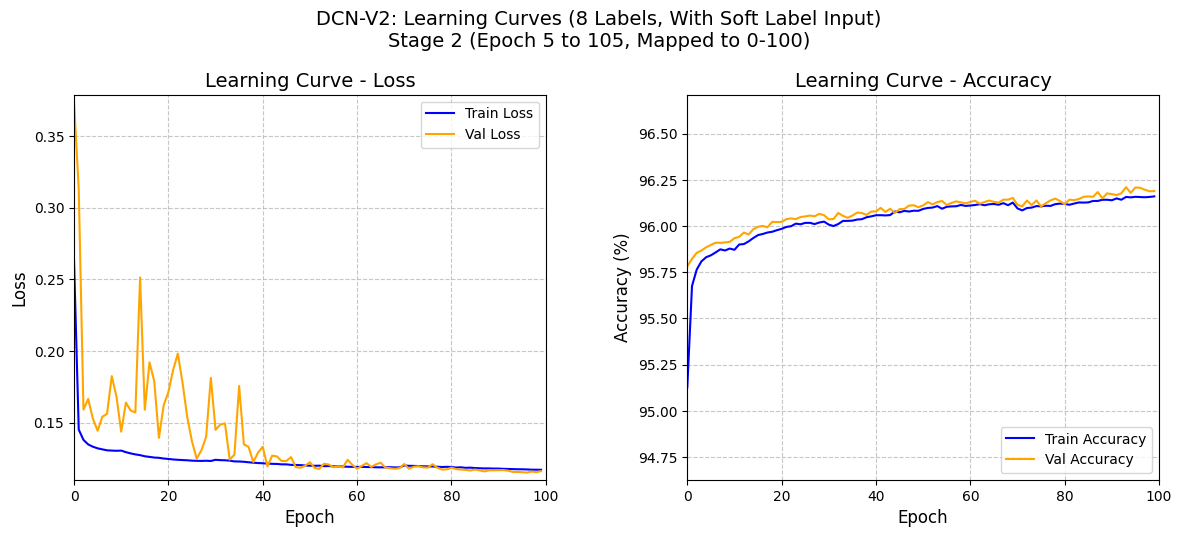

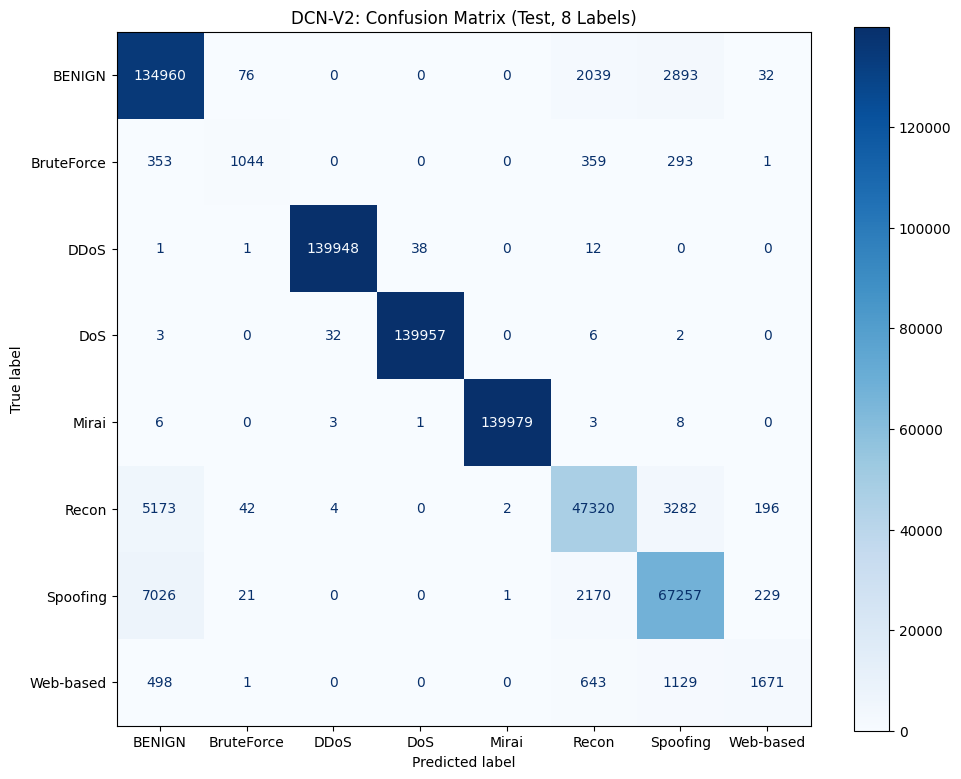

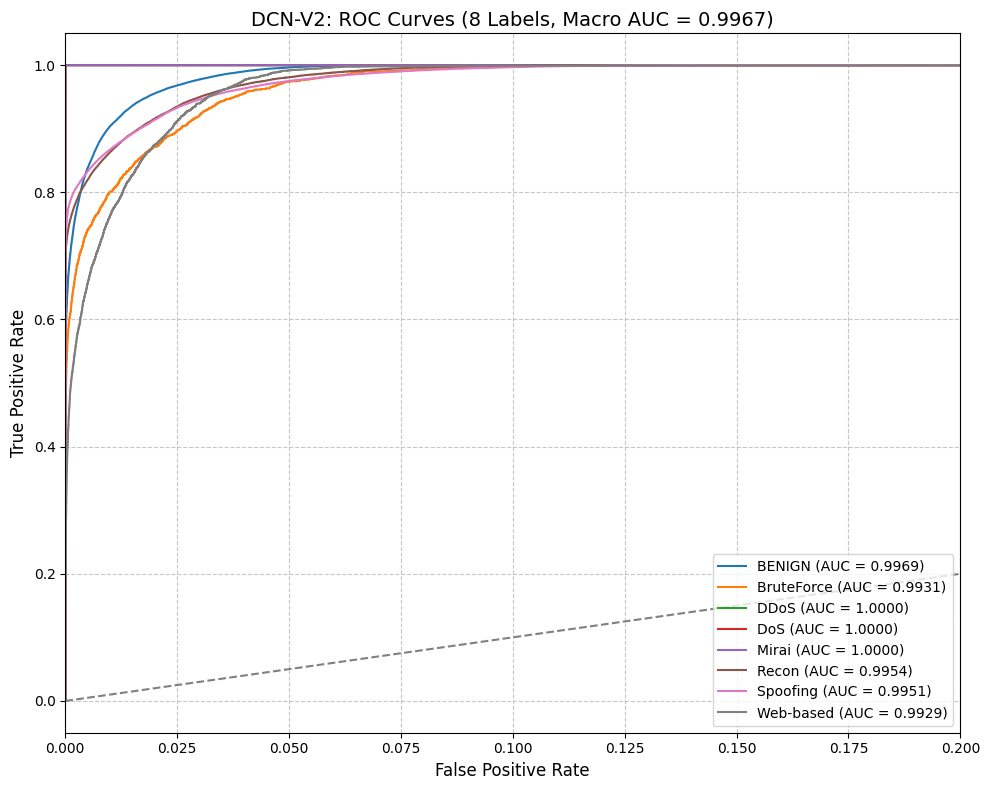

📈 ROC-AUC Scores (One-vs-Rest):
BENIGN: 0.9969
BruteForce: 0.9931
DDoS: 1.0000
DoS: 1.0000
Mirai: 1.0000
Recon: 0.9954
Spoofing: 0.9951
Web-based: 0.9929
📈 Macro-average ROC-AUC: 0.9967
Shape of test_features: (698715, 46)


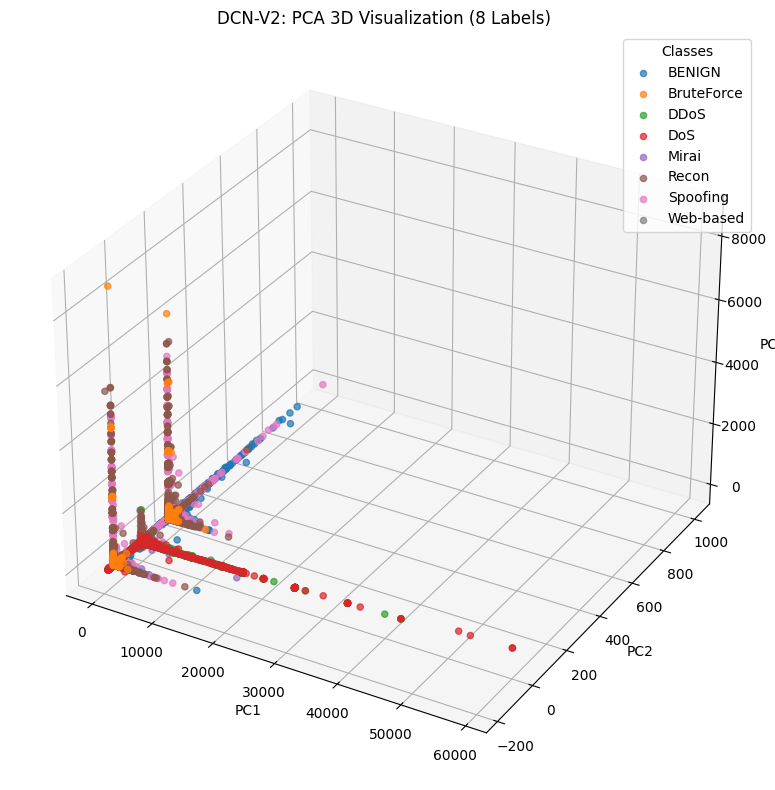

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 57.67 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.1236
Val Loss trung bình: 0.1382
Train Accuracy trung bình: 96.04%
Val Accuracy trung bình: 96.08%


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_8labels_with_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_8labels_with_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_8labels_with_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_8labels_with_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_8labels_with_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_8labels_with_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_8labels_with_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_8labels_with_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_8labels_with_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2 (8 nhãn, với soft label input)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 8 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 8) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (8, 8):
    raise ValueError(f"Confusion matrix phải có shape (8, 8), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Ánh xạ nhãn cho bài toán 8 nhãn
label_map = {
    0: 'BENIGN',
    1: 'BruteForce',
    2: 'DDoS',
    3: 'DoS',
    4: 'Mirai',
    5: 'Recon',
    6: 'Spoofing',
    7: 'Web-based'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Tăng kích thước để dễ đọc

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Learning Curve - Loss", fontsize=14)
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y dựa trên giá trị thực tế
loss_min = min(train_losses_plot.min(), val_losses_plot.min())
loss_max = max(train_losses_plot.max(), val_losses_plot.max())
ax1.set_ylim(loss_min - 0.005, loss_max + 0.005)  # Thêm padding nhỏ để dễ nhìn

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Learning Curve - Accuracy", fontsize=14)
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
# Điều chỉnh trục Y dựa trên giá trị thực tế
acc_min = min(train_accuracies_plot.min(), val_accuracies_plot.min())
acc_max = max(train_accuracies_plot.max(), val_accuracies_plot.max())
ax2.set_ylim(acc_min - 0.5, acc_max + 0.5)  # Thêm padding nhỏ để dễ nhìn

# Thêm tiêu đề chính
plt.suptitle("DCN-V2: Learning Curves (8 Labels, With Soft Label Input)\nStage 2 (Epoch 5 to 105, Mapped to 0-100)", 
             fontsize=14, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_dcnv2_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("DCN-V2: Confusion Matrix (Test, 8 Labels)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_dcnv2_8labels_with_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC (Multi-class, One-vs-Rest)
plt.figure(figsize=(10, 8))  # Tăng kích thước biểu đồ
roc_auc_scores = []
for i in range(8):
    # Tính ROC cho từng nhãn (one-vs-rest)
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

# Tính ROC-AUC trung bình (macro-average)
roc_auc_macro = np.mean(roc_auc_scores)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"DCN-V2: ROC Curves (8 Labels, Macro AUC = {roc_auc_macro:.4f})", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
# Thu hẹp trục X từ 0 đến 0.2
plt.xlim(0, 0.2)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_dcnv2_8labels_with_soft_label_input.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Scores (One-vs-Rest):")
for i, score in enumerate(roc_auc_scores):
    print(f"{class_names[i]}: {score:.4f}")
print(f"📈 Macro-average ROC-AUC: {roc_auc_macro:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("DCN-V2: PCA 3D Visualization (8 Labels)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_dcnv2_8labels_with_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **CODE TẢI KẾT QUẢ**

In [12]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/results"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

Tải xuống results.zip:


/kaggle/working/results.zip